<a href="https://colab.research.google.com/github/sourangshupal/Yolov5_Custom_Training/blob/main/Roboflow_Custom_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/yolov5setup/
!unzip dataset.zip

/content/drive/MyDrive/yolov5setup
Archive:  dataset.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/1-arc-de-triomphe-paris-france_jpg.rf.9d7dd30d30bd14b36385136c264a6147.jpg  
 extracting: test/images/1-london-eye-2009_jpg.rf.f6521a3bddce631dfbb8b58326cae453.jpg  
 extracting: test/images/1-the_great_wall_of_china_at_jinshanling-edit_jpg.rf.3b968f7432128eb779815273f6736925.jpg  
 extracting: test/images/10-dome-of-the-rock-on-the-temple-mount-in-the-old-city-of-jerusalem-israel-2apyxr4_jpg.rf.c85ddbaef02da1eb5331b9abbe4d4180.jpg  
 extracting: test/images/11-170px-toronto_-_on_-_cn_tower_bei_nacht2_jpg.rf.fe9fbeb616fe992667237170cecafe33.jpg  
 extracting: test/images/12-arc-de-triomphe-paris-france-france_l_jpeg.rf.4261ccb2acd616a6390b762135a82aa5.jpg  
 extracting: test/images/12-rialto-bridge-venice-italy_jpg.rf.b83493513feb00bd16c0b33b24b6caa

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16413, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 16413 (delta 0), reused 3 (delta 0), pack-reused 16408
Receiving objects: 100% (16413/16413), 14.90 MiB | 12.05 MiB/s, done.
Resolving deltas: 100% (11265/11265), done.
/content/drive/MyDrive/yolov5setup/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.1/715.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [ ]:
# install dependencies as necessary
# !pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [ ]:
# this is the YAML file
%cat /content/drive/MyDrive/yolov5setup/data.yaml

train: /content/drive/MyDrive/yolov5setup/train/images
val: /content/drive/MyDrive/yolov5setup/valid/images
test: /content/drive/MyDrive/yolov5setup/test/images

nc: 25
names: ['Acropolis_of_Athens', 'Arc de Triomphe', 'Big_Ben', 'BlueMosque', 'Brandenburg_Gate', 'CN_Tower', 'Casa_Mila', 'Christ the Redeemer', 'Colosseum', 'Deoksugung', 'Eiffel_Tower', 'Forbidden_City', 'Gardens_by_the_Bay', 'Great_Wall_of_China', 'HollyWood Sign', 'Jerusalem', 'Leaning_Tower_of_Pisa', 'London_Eye', 'Marina Bay', 'Opera_House', 'Pantheon', 'Rialto_Bridge', 'Statue_of_Liberty_National_Monument', 'Taj Mahal', 'pyramid']

roboflow:
  workspace: kgitbank
  project: landmark-detection-jqu66
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/kgitbank/landmark-detection-jqu66/dataset/2

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open("/content/drive/MyDrive/yolov5setup/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/drive/MyDrive/yolov5setup/yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/drive/MyDrive/yolov5setup/yolov5/models/custom_yolov5m.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
!cat /content/drive/MyDrive/yolov5setup/data.yaml

train: /content/drive/MyDrive/yolov5setup/train/images
val: /content/drive/MyDrive/yolov5setup/valid/images
test: /content/drive/MyDrive/yolov5setup/test/images

nc: 25
names: ['Acropolis_of_Athens', 'Arc de Triomphe', 'Big_Ben', 'BlueMosque', 'Brandenburg_Gate', 'CN_Tower', 'Casa_Mila', 'Christ the Redeemer', 'Colosseum', 'Deoksugung', 'Eiffel_Tower', 'Forbidden_City', 'Gardens_by_the_Bay', 'Great_Wall_of_China', 'HollyWood Sign', 'Jerusalem', 'Leaning_Tower_of_Pisa', 'London_Eye', 'Marina Bay', 'Opera_House', 'Pantheon', 'Rialto_Bridge', 'Statue_of_Liberty_National_Monument', 'Taj Mahal', 'pyramid']

roboflow:
  workspace: kgitbank
  project: landmark-detection-jqu66
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/kgitbank/landmark-detection-jqu66/dataset/2

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/yolov5setup/yolov5
!python train.py --img 416 --batch 64 --epochs 100 --data '/content/drive/MyDrive/yolov5setup/data.yaml' --cfg /content/drive/MyDrive/yolov5setup/yolov5/models/custom_yolov5m.yaml --weights '' --name yolov5m_results

/content/drive/MyDrive/yolov5setup/yolov5
2024-02-19 13:44:00.122554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 13:44:00.122626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 13:44:00.124695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=, cfg=/content/drive/MyDrive/yolov5setup/yolov5/models/custom_yolov5m.yaml, data=/content/drive/MyDrive/yolov5setup/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=64, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve

# Evaluate Custom YOLOv5 Detector Performance

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

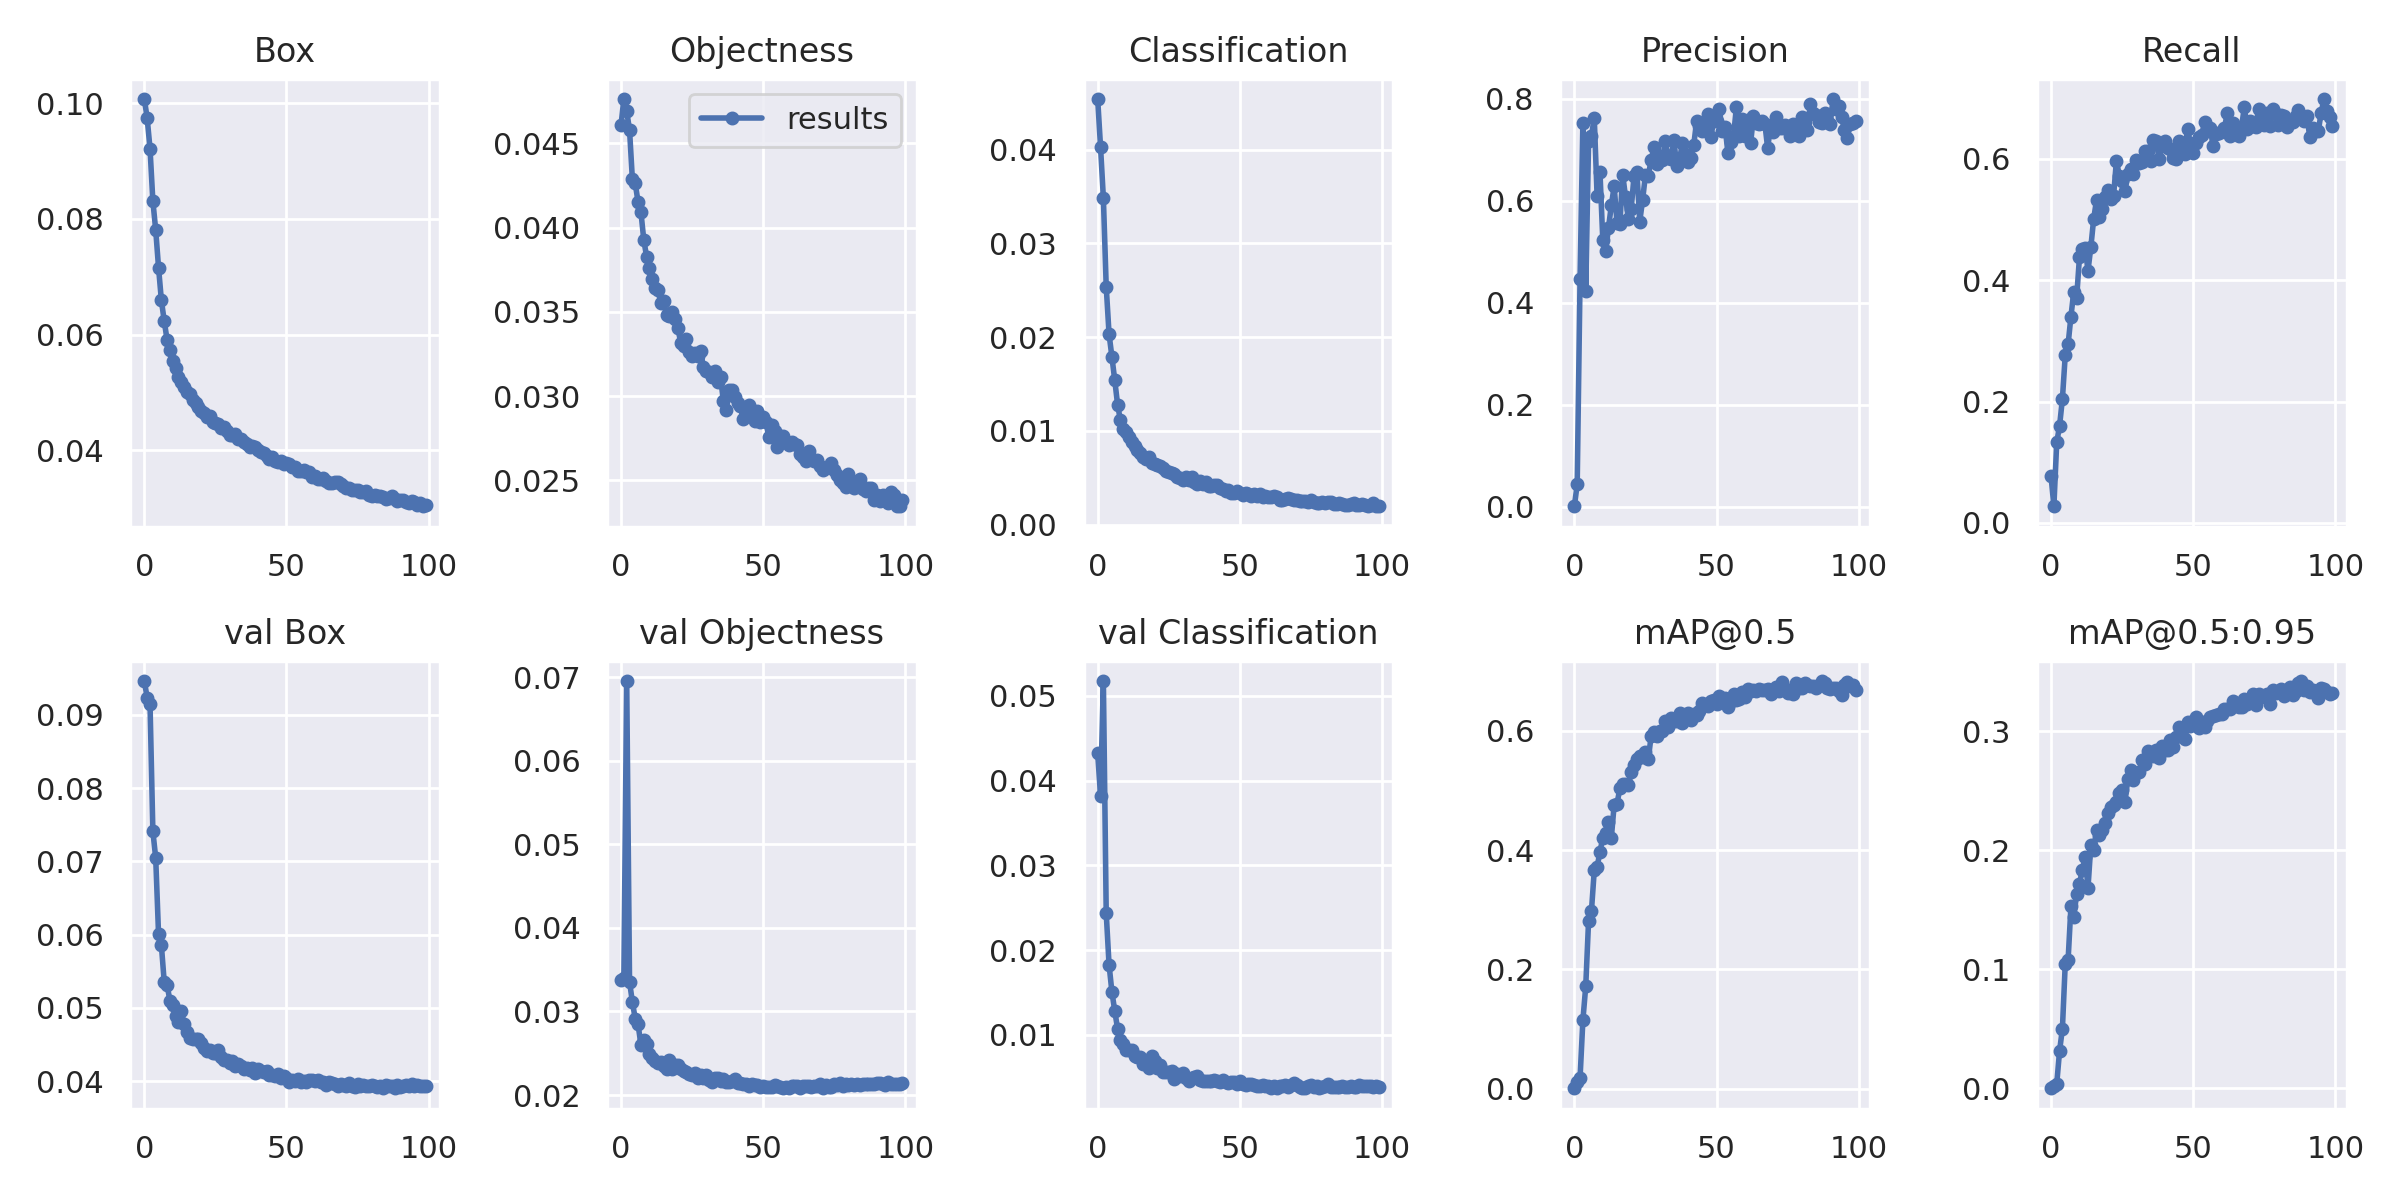

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/drive/MyDrive/yolov5setup/yolov5/runs/train/yolov5m_results5/results.png', width=1000)  # view results.png

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5m_results5/weights

best.pt  last.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
#%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5m_results5/weights/best.pt --img 416 --conf 0.4 --source /content/drive/MyDrive/yolov5setup/dataset/test/images

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/yolov5setup/dataset/test/images', update=False, view_img=False, weights=['runs/train/yolov5m_results5/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 308 layers, 21053802 parameters, 0 gradients, 50.4 GFLOPS
image 1/1059 /content/drive/MyDrive/yolov5setup/dataset/test/image

In [1]:
# #display inference on ALL test images
# #this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/drive/MyDrive/yolov5setup/yolov5/runs/detect/exp/wh_dresscode_0006.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive